In [268]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import warnings
from pathlib import Path
from v1dd_public import ARTIFACT_DIR
from scipy import stats
from v1dd_public import utils
from allen_v1dd.client import OPhysClient
from allen_v1dd.client.ophys_session import OPhysSession
from allen_v1dd.stimulus_analysis import LocallySparseNoise
import statsmodels.stats.multicomp as multi
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from collections import defaultdict
from scipy.stats import ks_2samp
from allen_v1dd.client import OPhysClient

np.random.seed(42) # set seed for reproducibility

In [269]:
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [270]:
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2 

In [271]:
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


In [490]:
base_folder = "/home/naomi/Desktop/data/V1dd_nwbs"
client = OPhysClient(base_folder)
session_ids = client.get_all_session_ids()

In [480]:
def find_subfields(cell, lsn_vals, pvals, design_matrix, response_thresh_alpha=0.05, visualize=False):
    '''
    Find the subfield of a cell that responds to the LSN stimulus.
    '''

    # pull out the LSN values and p-values for the cell
    lsn_vals_cell = lsn_vals[:, cell]
    pvals_cell = pvals[:, cell]

    # find the responsive trials and corresponding stimuli for those trials 
    is_trial_responsive = pvals_cell < response_thresh_alpha
    design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 3.5) & (counts_stim_for_resp_trials_on >= 7)  # threshold for significance

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -3.5) & (counts_stim_for_resp_trials_off >= 7)  # threshold for significance

    # check for "islands"
    on_subfield_pixels_all = np.where(on_results == True)
    on_subfield = []
    if on_results.sum() > 1:
        biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
        on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
        for x, y in zip(on_subfield_pixels_all[0], on_subfield_pixels_all[1]):
            distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
            if (distance < 0.1) or (distance > 1.5):
                continue
            elif distance < 1.5:
                on_subfield.append([x, y])
    elif on_results.sum() == 1:
        on_subfield.append([on_subfield_pixels_all[0][0], on_subfield_pixels_all[1][0]])
    on_subfield = np.array(on_subfield)
    on_results_new = np.zeros_like(on_results)
    if on_subfield.size > 0:
        on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1
    
    off_subfield_pixels_all = np.where(off_results == True)
    off_subfield = []
    if off_results.sum() > 1:
        biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
        off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
        for x, y in zip(off_subfield_pixels_all[0], off_subfield_pixels_all[1]):
            distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
            if (distance < 0.1) or (distance > 1.5):
                continue
            elif distance < 1.5:
                off_subfield.append([x, y])
    elif off_results.sum() == 1:
        off_subfield.append([off_subfield_pixels_all[0][0], off_subfield_pixels_all[1][0]])
    off_subfield = np.array(off_subfield)
    off_results_new = np.zeros_like(off_results)
    if off_subfield.size > 0:
        off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

    if visualize:
        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        axs[1, 3].axis('off')

        return on_subfield, off_subfield, fig

    return on_subfield, off_subfield, None


In [516]:
def get_mouse_name(mouse_id):

    # Set up mouse id mapping to index metrics dataframe correctly
    mouse_id_mapping = {
        427836: "slc5",
        438833: "slc4",
        416296: "teto1",
        409828: "slc2",
    }

    return mouse_id_mapping[mouse_id]

In [517]:
from itertools import compress
def select_rois(session, plane, metrics_df=None, unduplicated=False):
    rois = session.get_rois(plane)
    if unduplicated:
        if metrics_df is not None:
            rois = metrics_df[
                (metrics_df["mouse_id"] == get_mouse_name(session.get_mouse_id()))
                & (metrics_df["column"] == str(session.get_column_id()))
                & (metrics_df["volume"] == str(session.get_volume_id()))
                & (metrics_df["plane"] == plane)
            ].cell_index.values
            return list(rois)
        else:
            print("Cannot find any unduplicated ROIs...where is metrics_df")
    else:
        return list(
            compress(
                rois,
                session.is_roi_valid(plane=plane),
            )
        )

In [518]:
ARTIFACT_DIR = Path('/home/naomi/Desktop/code/v1dd-public/artifacts')
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

ImportError: cannot import name 'select_rois' from 'v1dd_public' (/home/naomi/Desktop/code/v1dd-public/v1dd_public/__init__.py)

In [520]:
s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000

subfield_results = {
    'session': [],
    'mouse_id': [],
    'depth': [],
    'cell': [],
    'on_subfield': [],
    'off_subfield': [],
    'on_center_x': [],
    'on_center_y': [],
    'off_center_x': [],
    'off_center_y': [],
    'on_off_center_distance': [],
}

for session_id in session_ids:
    session = client.load_ophys_session(session_id)
    print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')
    
    for plane in session.get_planes():
        print(f'Analyzing plane {plane}')

        # Check if session has nonduplicated ROIs
        unduplicated_rois = select_rois(session, plane, metrics_df=cell_info, unduplicated=True)

        if len(unduplicated_rois) < 1:
            print(f"\tNo unduplicated ROIs found for {session_id} plane {plane}")
            continue

        all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = utils.calc_lsn_p_vals_for_col_vol_plane(session,
                                            plane,
                                            sample_spontaneous,
                                            onset_delay,
                                            offset_delay)

        design_matrix, trial_template, frame_images = utils.get_plane_lsn_constants(session)

        if all_lsn_vals_in_colvol_plane.ndim == 1:
            all_lsn_vals_in_colvol_plane = all_lsn_vals_in_colvol_plane.reshape(1705, 1)
            all_pvals_in_colvol_plane = all_pvals_in_colvol_plane.reshape(1705, 1)

        elif all_lsn_vals_in_colvol_plane.ndim == 0:
            continue

        for cell in range(all_lsn_vals_in_colvol_plane.shape[1]):

            on_subfield, off_subfield, _ = find_subfields(cell, all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, design_matrix, 0.05, False)

            subfield_results['session'].append(session.get_session_id())
            subfield_results['mouse_id'].append(session.get_mouse_id())
            subfield_results['depth'].append(session.get_plane_depth(plane))
            subfield_results['cell'].append(cell_indices[cell])
            subfield_results['on_subfield'].append(on_subfield)
            subfield_results['off_subfield'].append(off_subfield)

            if on_subfield.size > 0:
                on_center_x = on_subfield[:, 1].mean()
                on_center_y = on_subfield[:, 0].mean()
                subfield_results['on_center_x'].append(on_center_x)
                subfield_results['on_center_y'].append(on_center_y)
            else:
                subfield_results['on_center_x'].append(None)
                subfield_results['on_center_y'].append(None)
            
            if off_subfield.size > 0:
                off_center_x = off_subfield[:, 1].mean()
                off_center_y = off_subfield[:, 0].mean()
                subfield_results['off_center_x'].append(off_center_x)
                subfield_results['off_center_y'].append(off_center_y)
            else:
                subfield_results['off_center_x'].append(None)
                subfield_results['off_center_y'].append(None)
            
            if on_subfield.size > 0 and off_subfield.size > 0:
                on_off_center_distance = np.sqrt((on_center_x - off_center_x)**2 + (on_center_y - off_center_y)**2)
                subfield_results['on_off_center_distance'].append(on_off_center_distance)
            else:
                subfield_results['on_off_center_distance'].append(None)
    
subfield_results_df = pd.DataFrame(subfield_results)
csv_tag = "_250317"
subfield_results_df.to_csv(ARTIFACT_DIR / f'subfield_results{csv_tag}.csv', index=False)

Loaded session M409828_11, mouse 409828, column 1, volume 1
Analyzing plane 1
	No unduplicated ROIs found for M409828_11 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M409828_11 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M409828_11 plane 3
Analyzing plane 4
	No unduplicated ROIs found for M409828_11 plane 4
Analyzing plane 5
	No unduplicated ROIs found for M409828_11 plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_11 plane 6
Loaded session M409828_12, mouse 409828, column 1, volume 2
Analyzing plane 1
	No unduplicated ROIs found for M409828_12 plane 1
Analyzing plane 2
	No unduplicated ROIs found for M409828_12 plane 2
Analyzing plane 3
	No unduplicated ROIs found for M409828_12 plane 3
Analyzing plane 4
	No unduplicated ROIs found for M409828_12 plane 4
Analyzing plane 5
	No unduplicated ROIs found for M409828_12 plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_12 plane 6
Loaded session M409828_13, mouse 409828, column 1, v

/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_23 plane 6
Loaded session M409828_24, mouse 409828, column 2, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_24 plane 6
Loaded session M409828_25, mouse 409828, column 2, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_25 plane 6
Loaded session M409828_31, mouse 409828, column 3, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_31 plane 6
Loaded session M409828_32, mouse 409828, column 3, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_32 plane 6
Loaded session M409828_33, mouse 409828, column 3, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_33 plane 6
Loaded session M409828_34, mouse 409828, column 3, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M409828_34 plane 6
Loaded session M409

/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_21 plane 6
Loaded session M416296_22, mouse 416296, column 2, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_22 plane 6
Loaded session M416296_23, mouse 416296, column 2, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_23 plane 6
Loaded session M416296_24, mouse 416296, column 2, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_24 plane 6
Loaded session M416296_25, mouse 416296, column 2, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M4

/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_32 plane 6
Loaded session M416296_33, mouse 416296, column 3, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_33 plane 6
Loaded session M416296_34, mouse 416296, column 3, volume 4
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_34 plane 6
Loaded session M416296_35, mouse 416296, column 3, volume 5
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_35 plane 6
Loaded session M416296_41, mouse 416296, column 4, volume 1
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4


/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 5


/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 6
	No unduplicated ROIs found for M416296_41 plane 6
Loaded session M416296_42, mouse 416296, column 4, volume 2
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3


/tmp/ipykernel_912711/1927541382.py:17: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_912711/1927541382.py:25: RuntimeWarning: Mean of empty slice.
  mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_vals_cell[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials


Analyzing plane 4
Analyzing plane 5
Analyzing plane 6
	No unduplicated ROIs found for M416296_42 plane 6
Loaded session M416296_43, mouse 416296, column 4, volume 3
Analyzing plane 1
Analyzing plane 2
Analyzing plane 3
Analyzing plane 4


KeyboardInterrupt: 

In [509]:
subfield_results_df = pd.DataFrame(subfield_results)

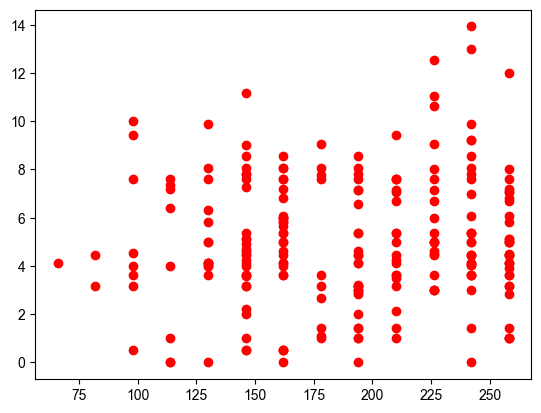

In [512]:
plt.scatter(subfield_results_df['depth'], subfield_results_df['on_center_distance'], c='r', label='ON Subfield')

(array([12., 10.,  8.,  3., 21., 42., 24., 29., 12.,  8., 27., 14.,  5.,
         6.,  3.,  2.,  1.,  2.,  1.,  1.]),
 array([ 0.        ,  0.69641941,  1.39283883,  2.08925824,  2.78567766,
         3.48209707,  4.17851648,  4.8749359 ,  5.57135531,  6.26777472,
         6.96419414,  7.66061355,  8.35703297,  9.05345238,  9.74987179,
        10.44629121, 11.14271062, 11.83913004, 12.53554945, 13.23196886,
        13.92838828]),
 <BarContainer object of 20 artists>)

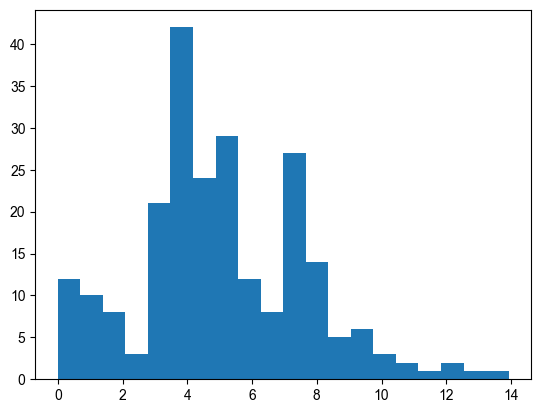

In [ ]:
plt.hist(subfield_results_df[subfield_results_df['depth['on_center_distance'].dropna(), bins=20)

Cell 6 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.605551275463989
Cell 10 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.0990195135927845
Cell 14 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.830951894845301
Cell 44 has both ON and OFF subfields
	Distance between ON and OFF subfields 4.47213595499958
Cell 70 has both ON and OFF subfields
	Distance between ON and OFF subfields 4.123105625617661
Cell 76 has both ON and OFF subfields
	Distance between ON and OFF subfields 2.692582403567252
Cell 83 has both ON and OFF subfields
	Distance between ON and OFF subfields 8.0
Cell 103 has both ON and OFF subfields
	Distance between ON and OFF subfields 4.6097722286464435
Cell 114 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.0413812651491097
Cell 138 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.905124837953327
Cell 140 has both ON and OFF subfields
	Distance between ON 

/tmp/ipykernel_912711/4202533602.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 4, figsize=(15, 5))


Cell 327 has both ON and OFF subfields
	Distance between ON and OFF subfields 2.0
Cell 331 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.0990195135927845
Cell 346 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.605551275463989
Cell 350 has both ON and OFF subfields
	Distance between ON and OFF subfields 1.4142135623730951
Cell 365 has both ON and OFF subfields
	Distance between ON and OFF subfields 0.0
Cell 379 has both ON and OFF subfields
	Distance between ON and OFF subfields 5.0
Cell 381 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.605551275463989
Cell 385 has both ON and OFF subfields
	Distance between ON and OFF subfields 3.605551275463989
Cell 412 has both ON and OFF subfields
	Distance between ON and OFF subfields 6.082762530298219
Cell 419 has both ON and OFF subfields
	Distance between ON and OFF subfields 4.924428900898052
Cell 427 has both ON and OFF subfields
	Distance between ON and OFF subfields 0.

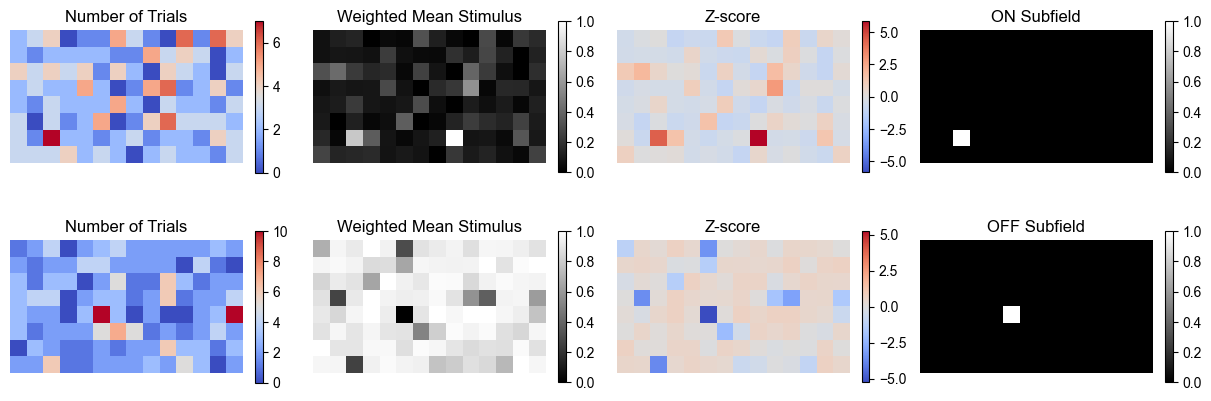

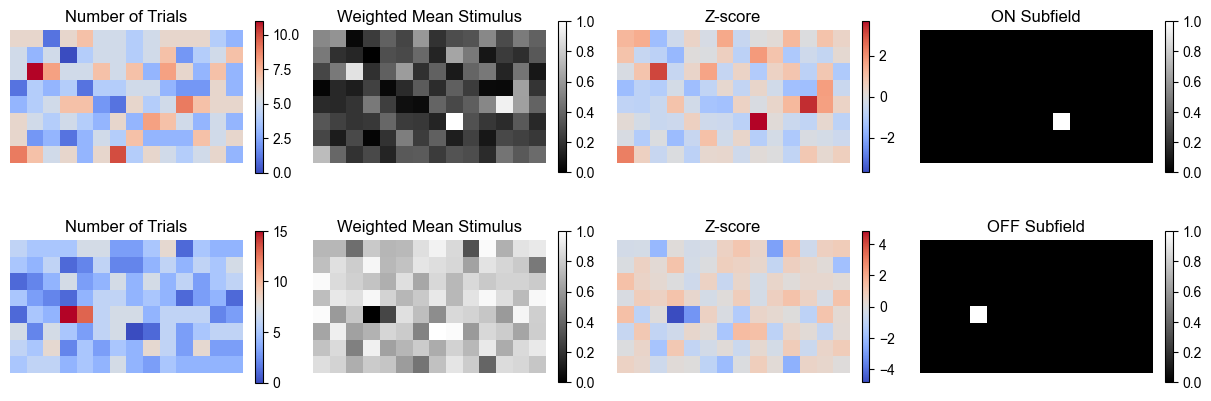

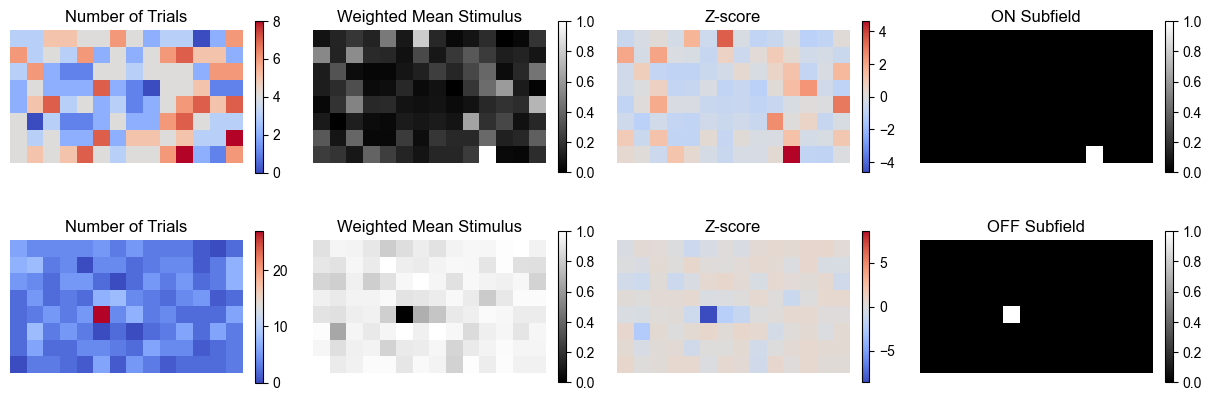

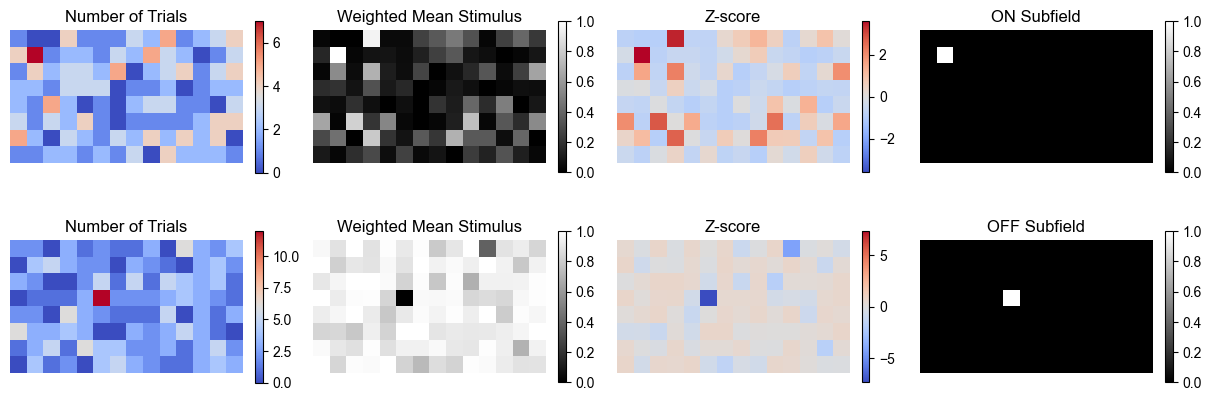

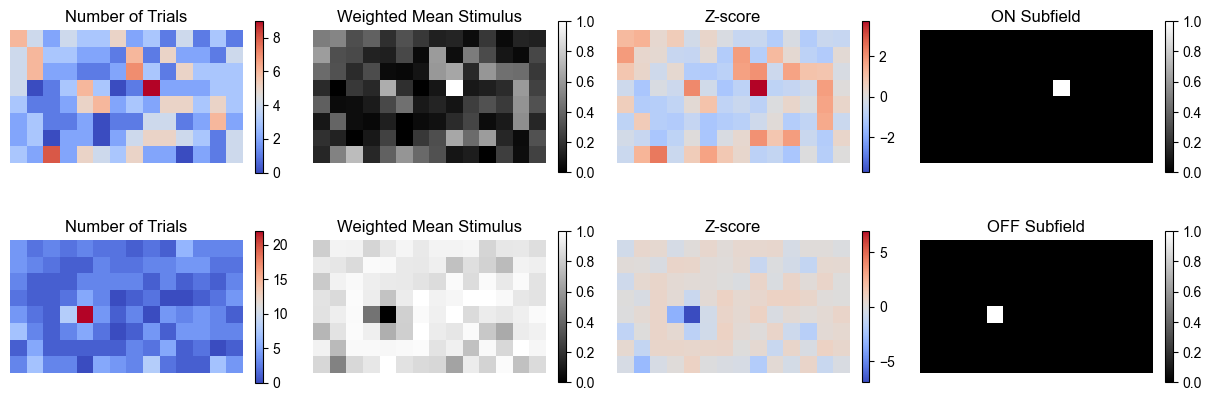

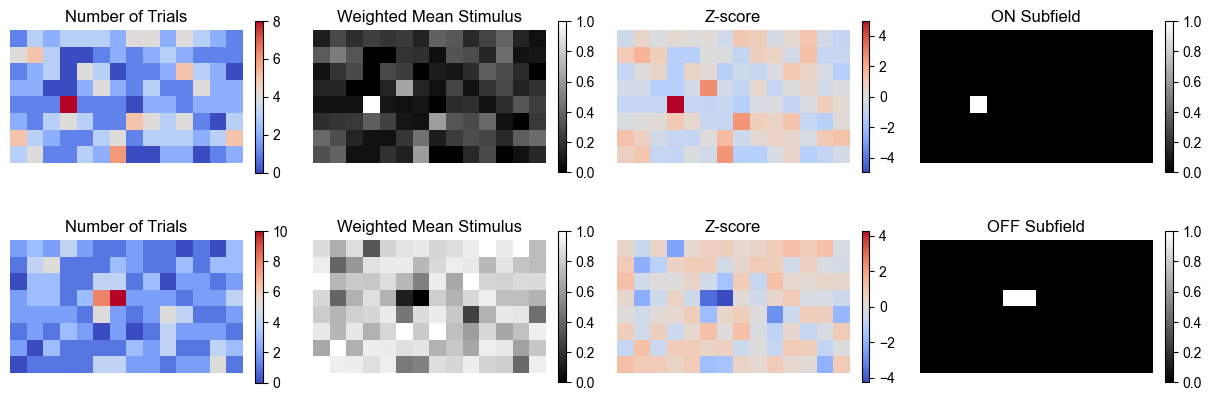

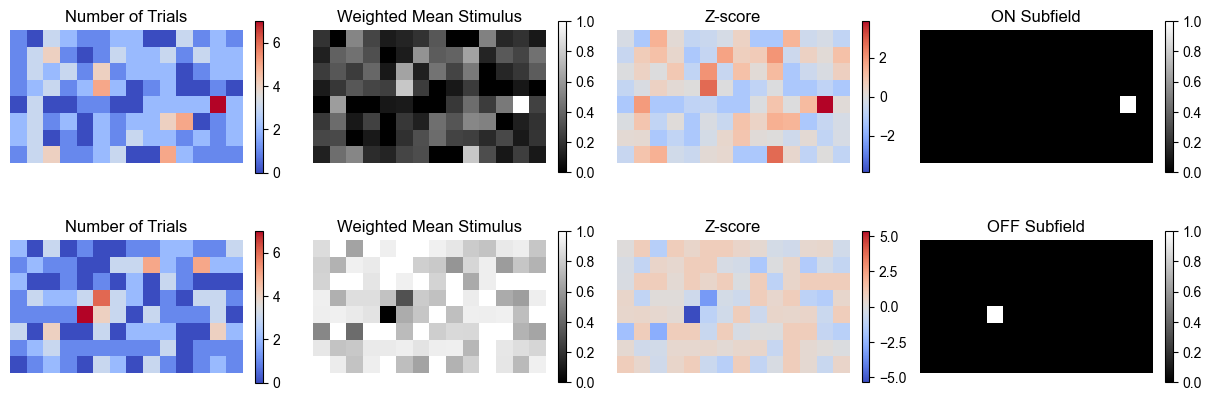

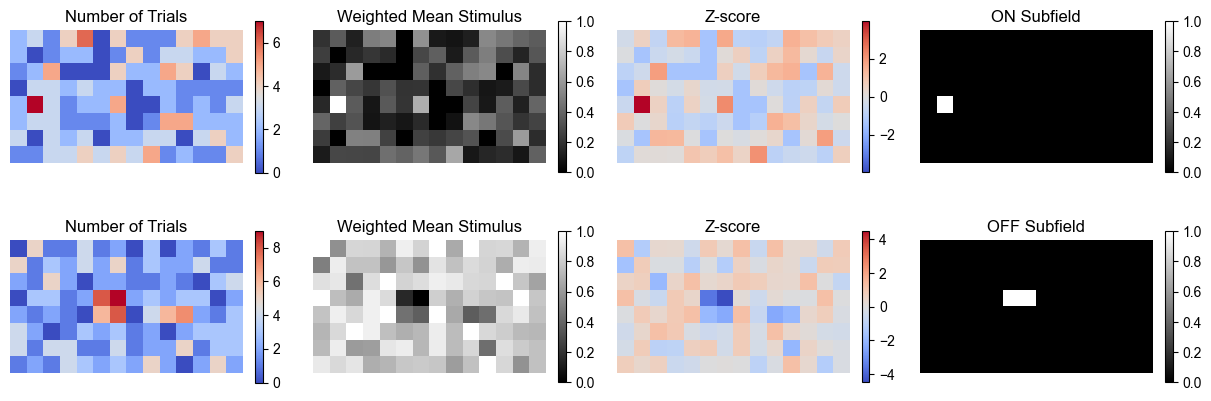

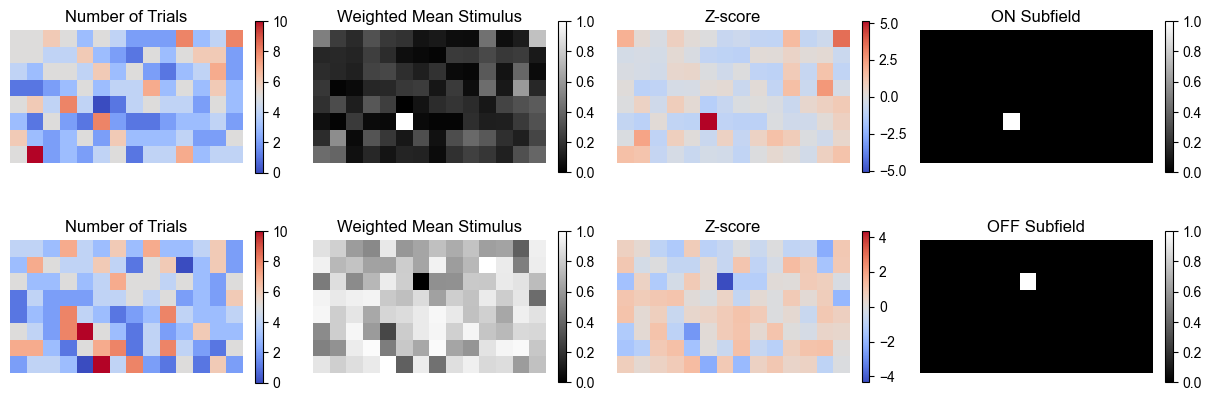

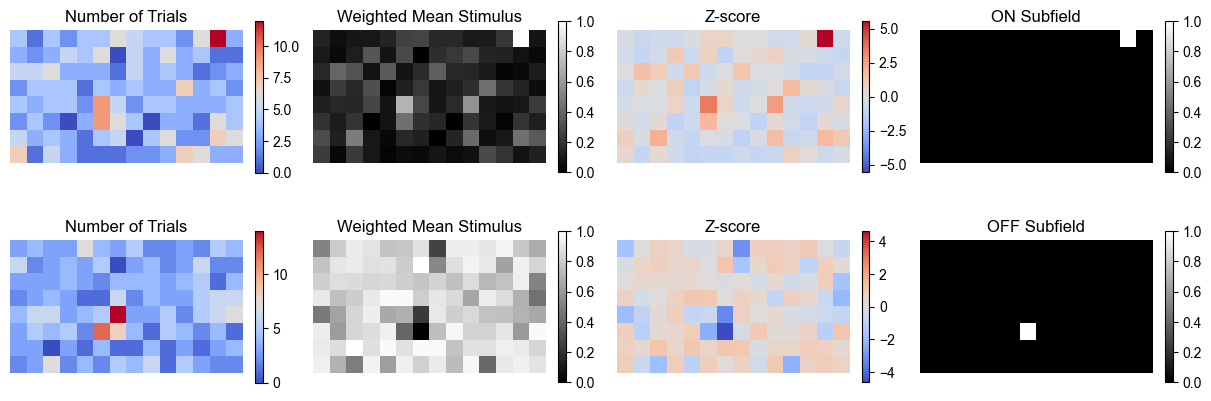

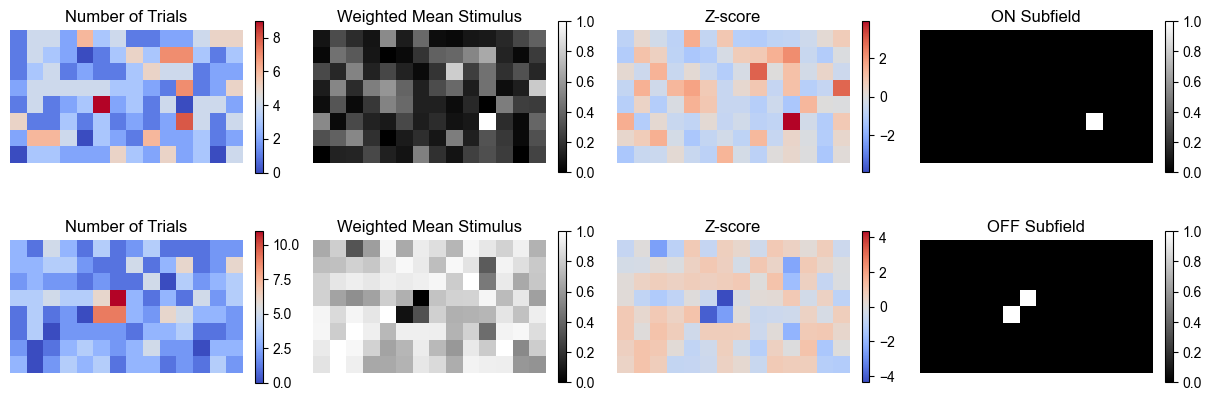

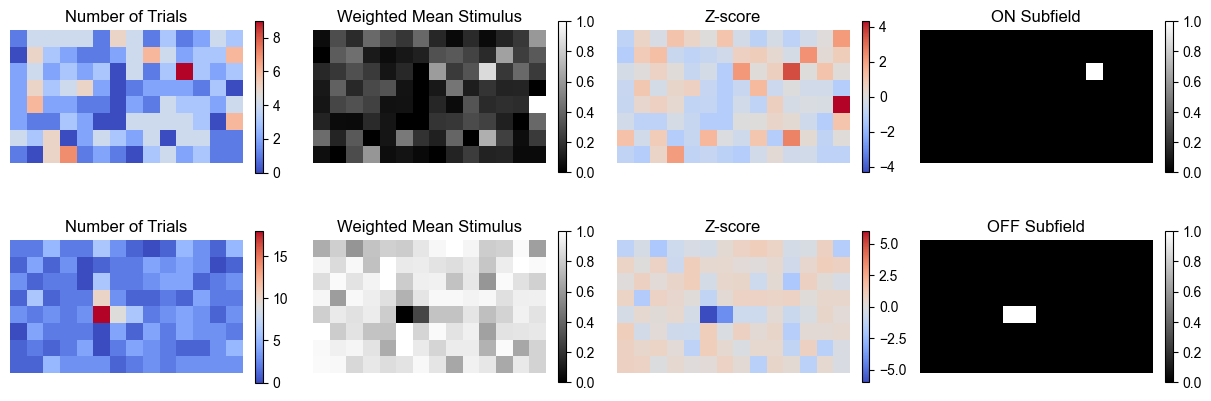

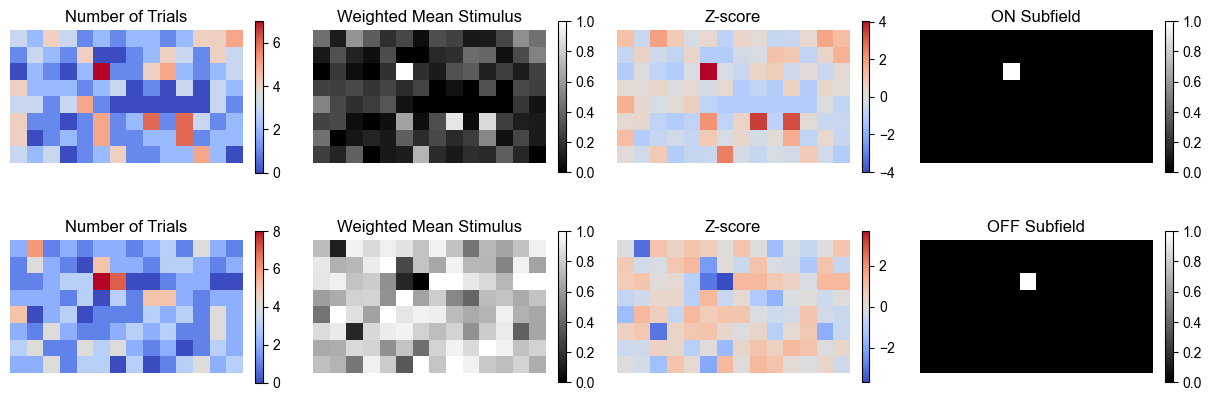

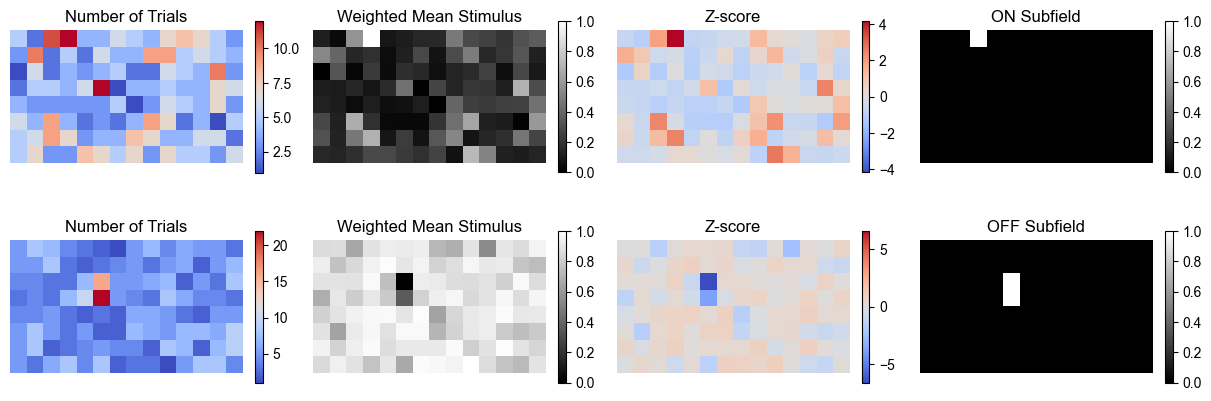

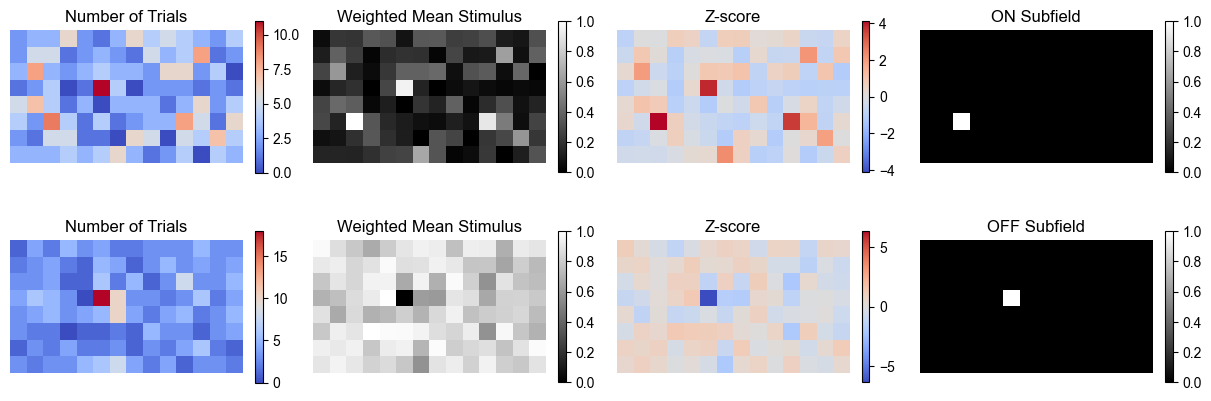

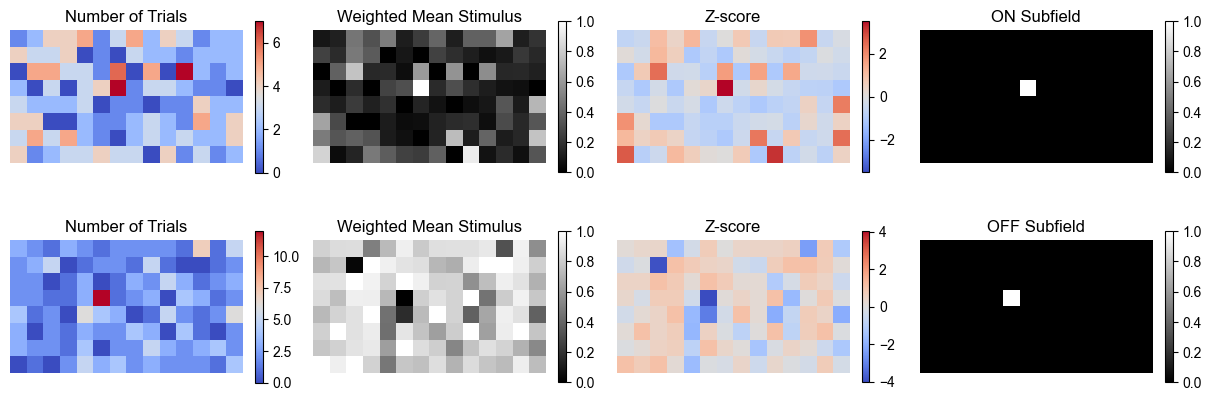

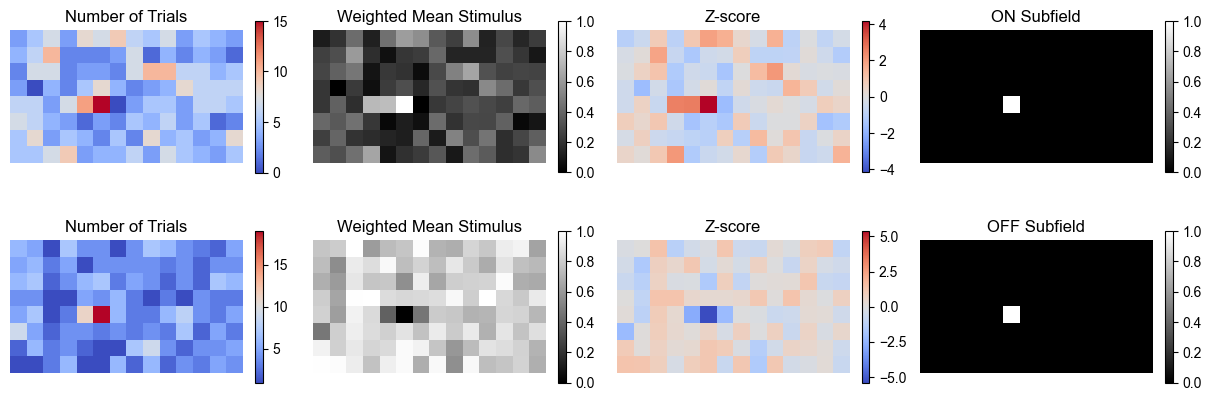

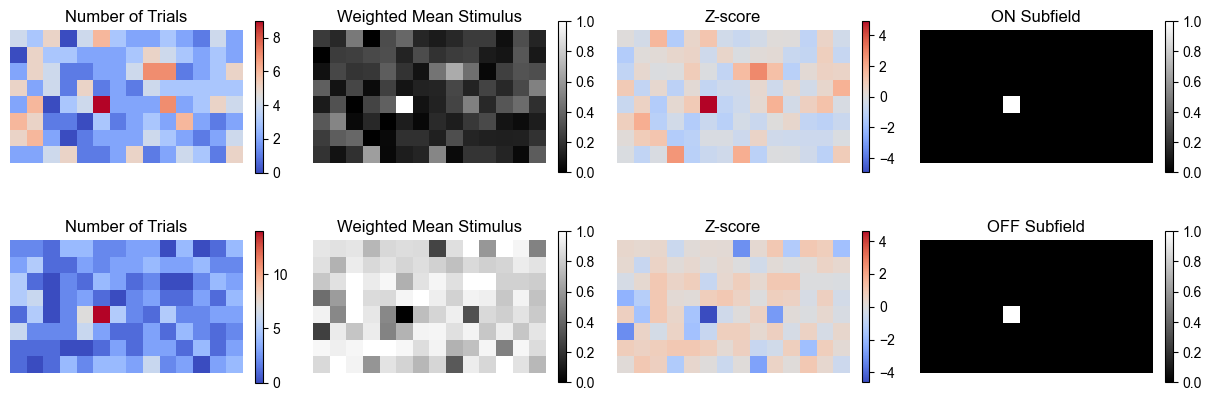

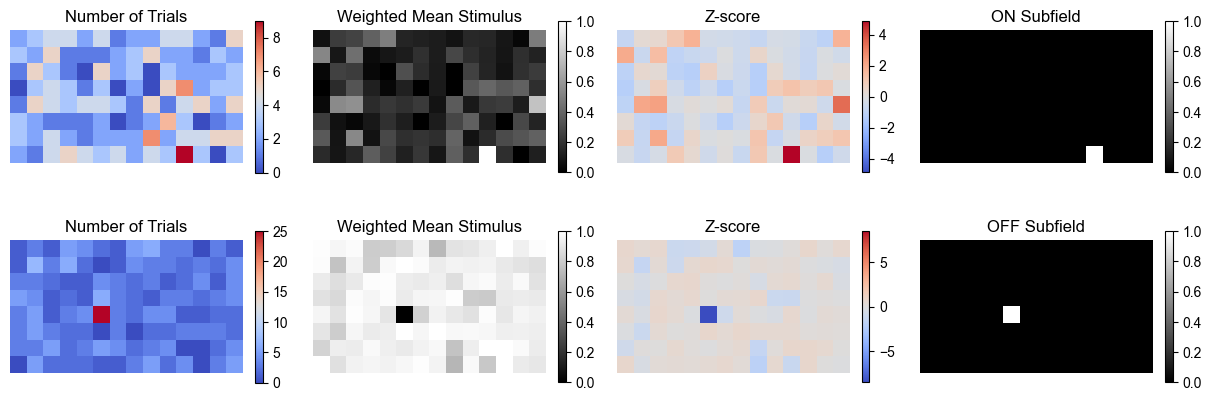

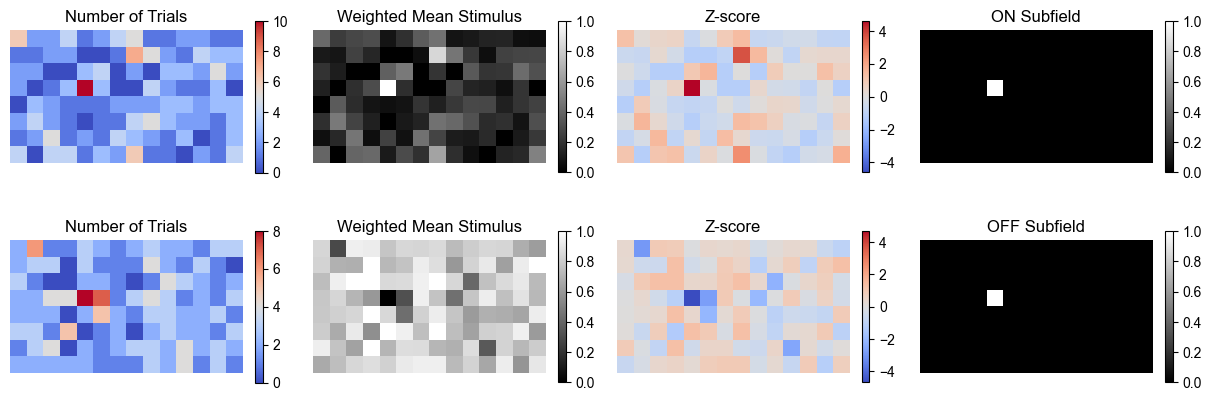

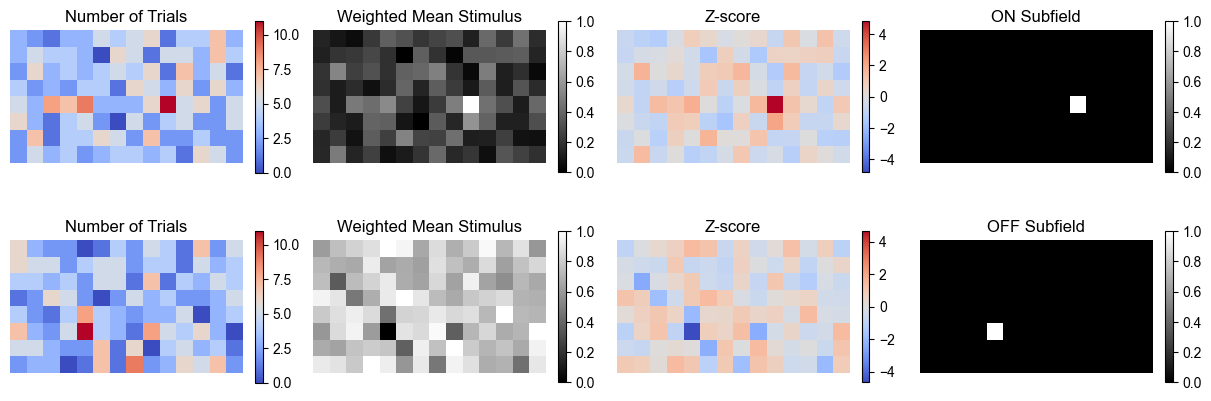

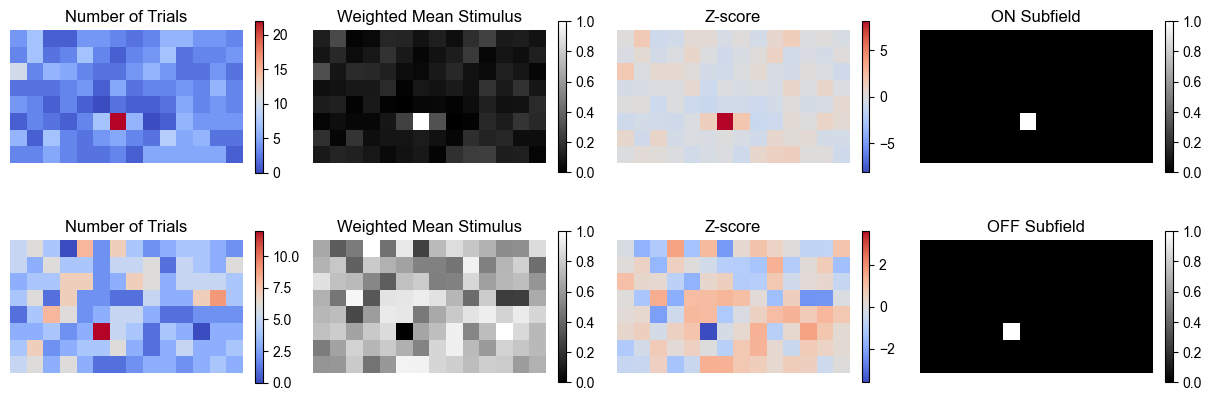

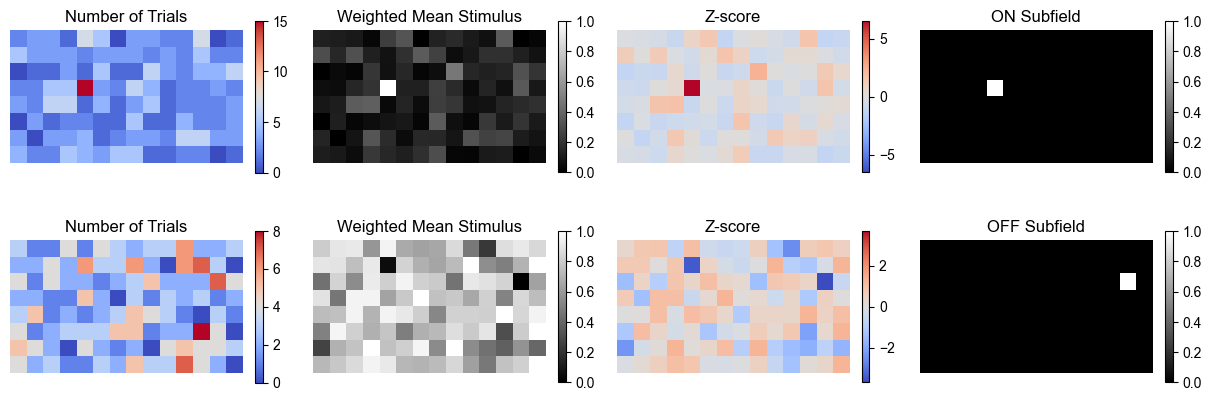

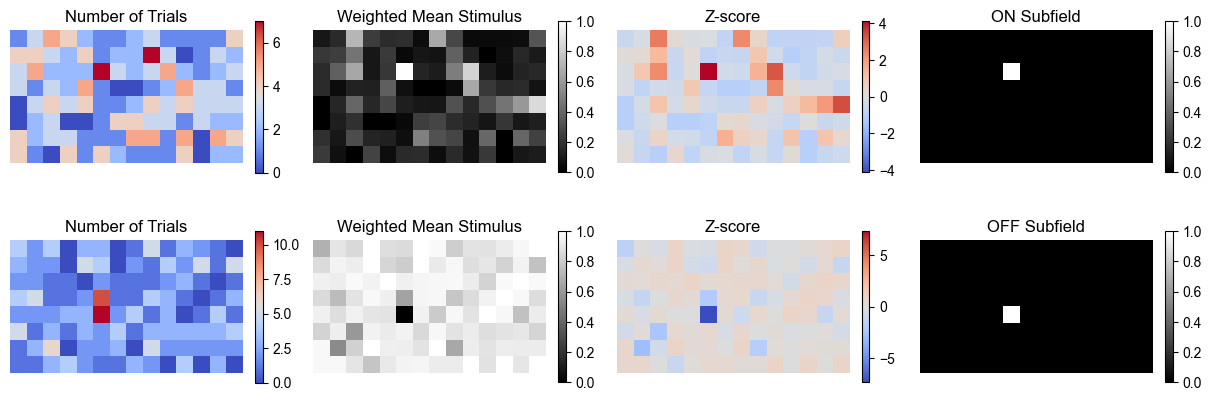

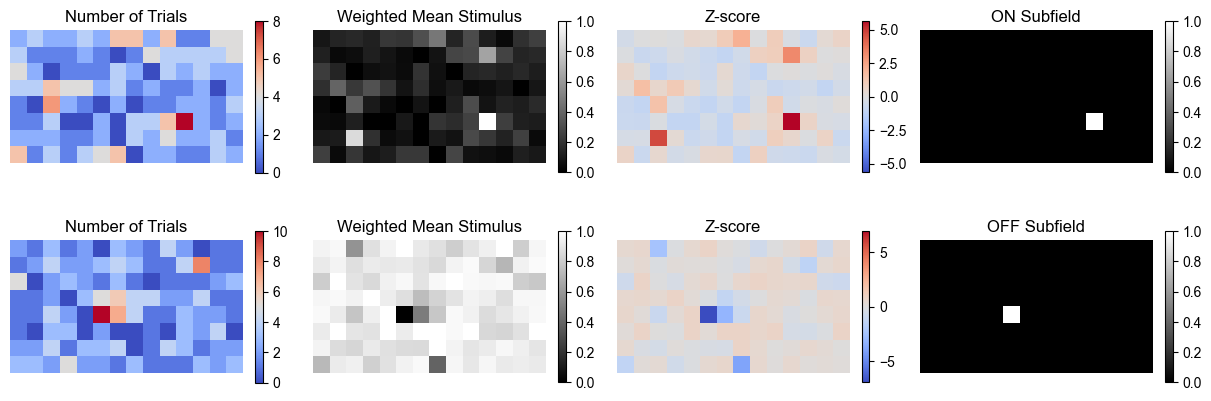

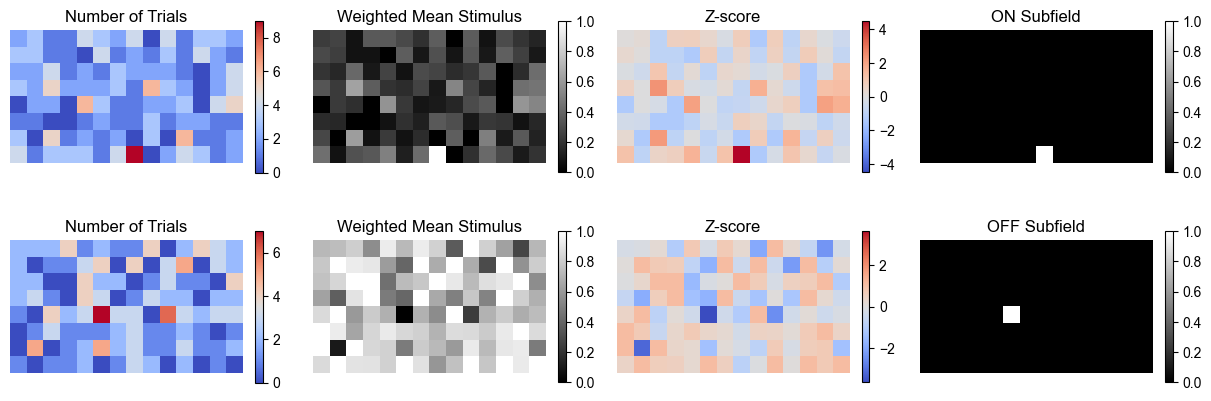

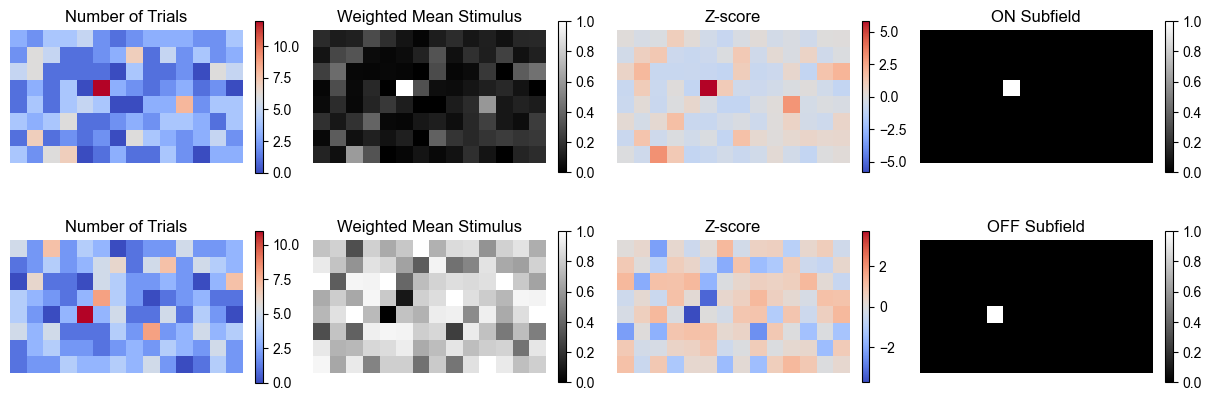

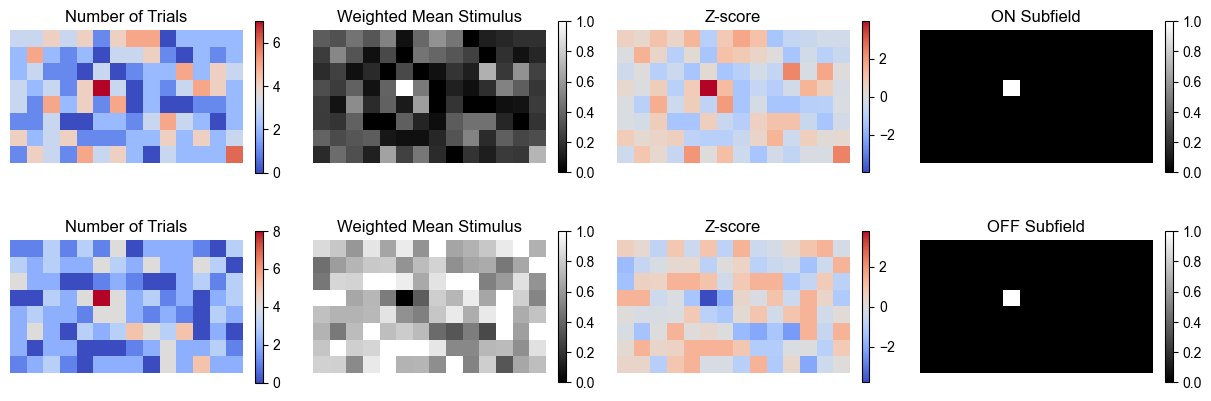

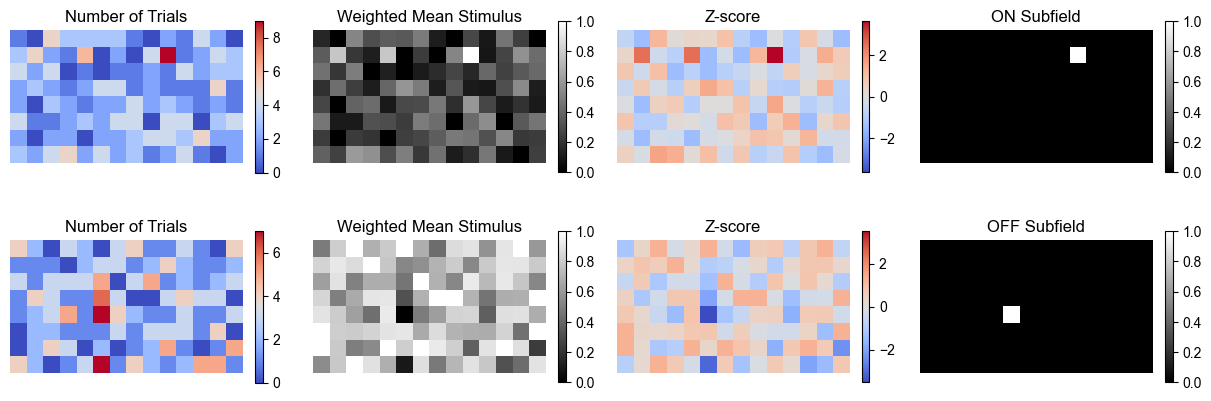

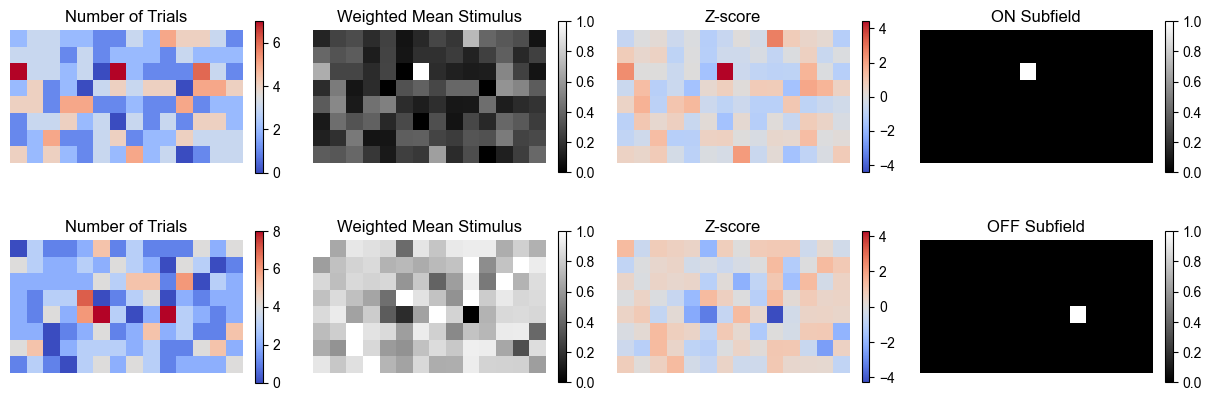

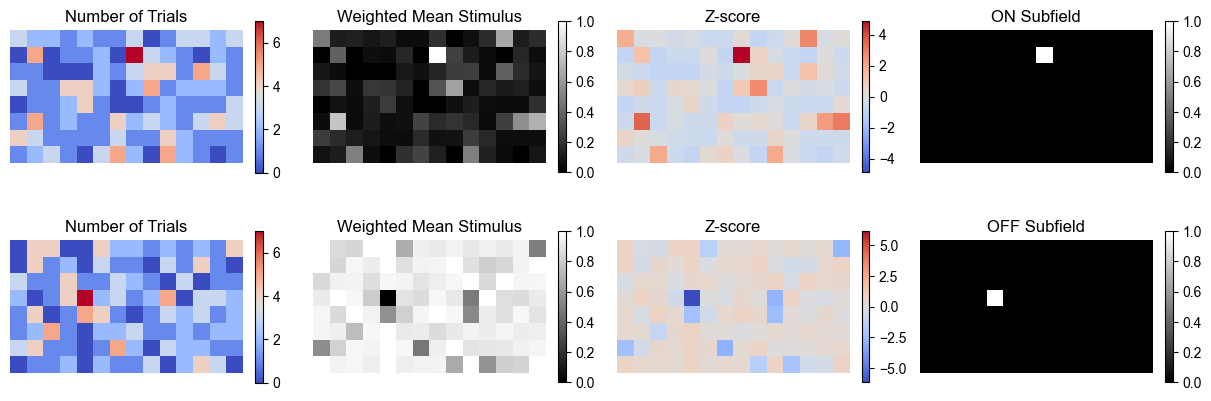

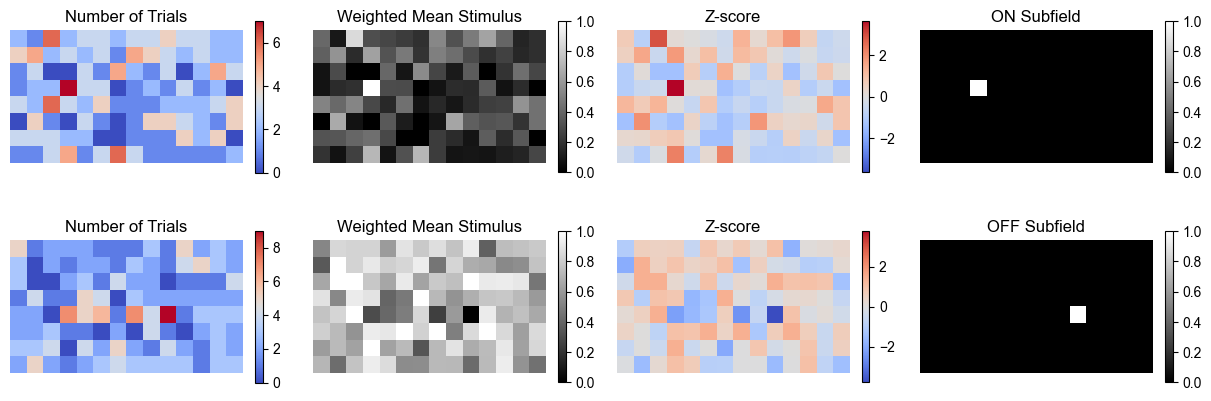

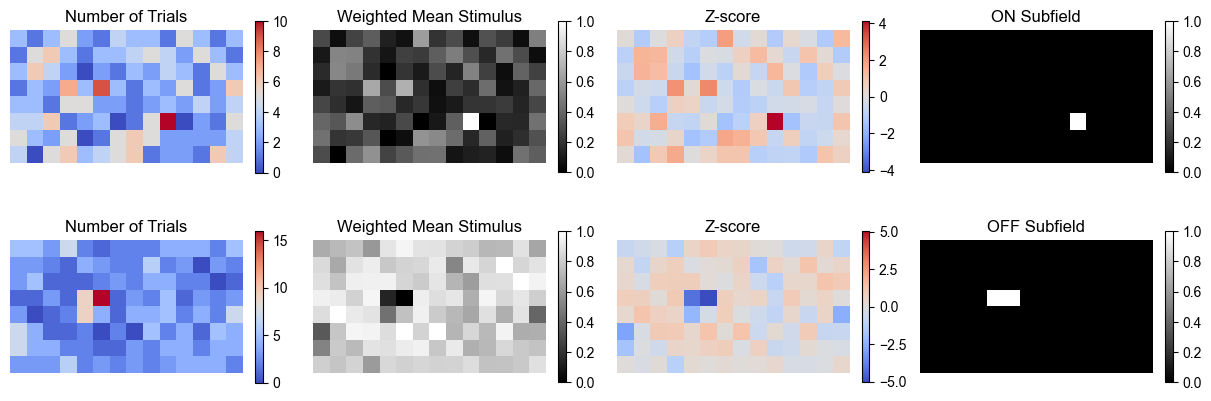

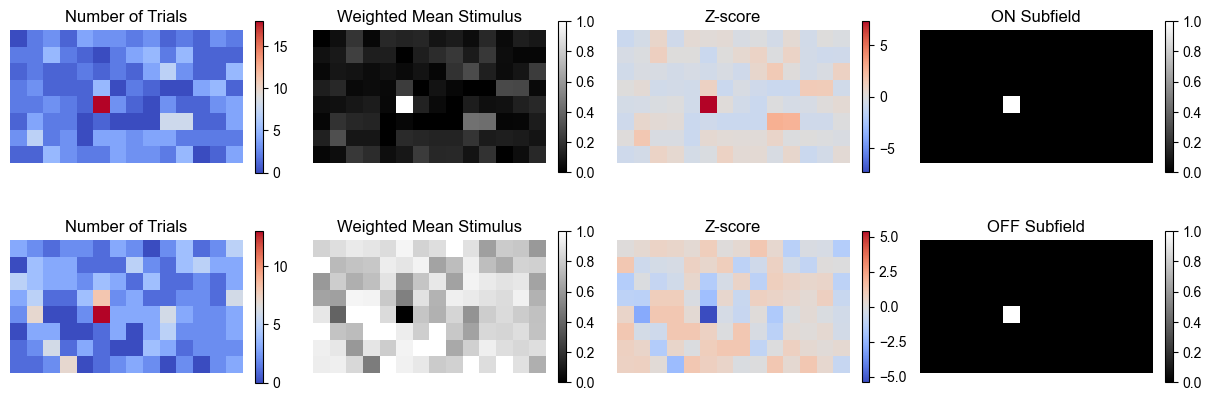

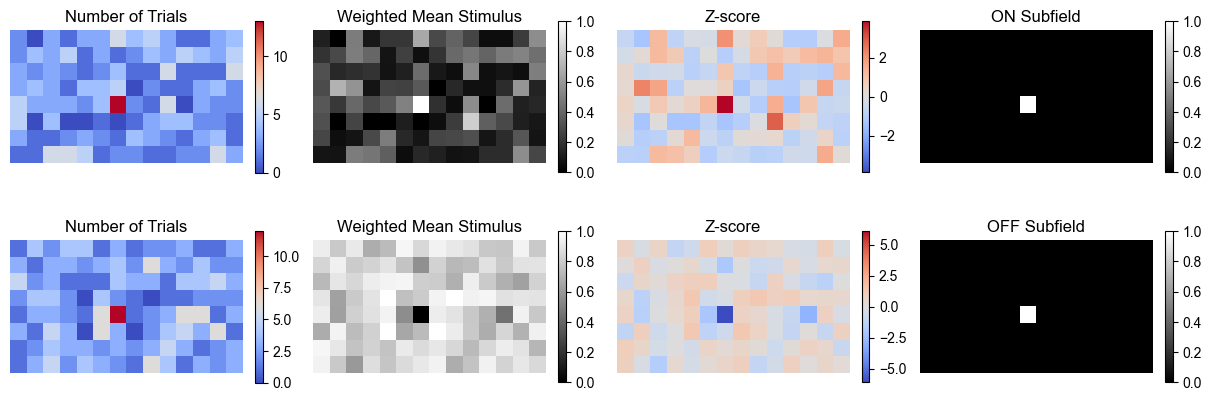

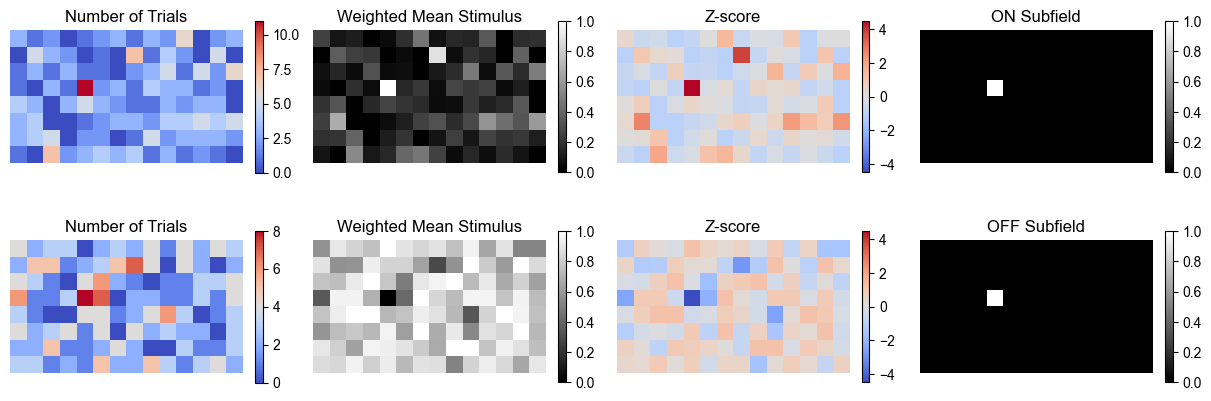

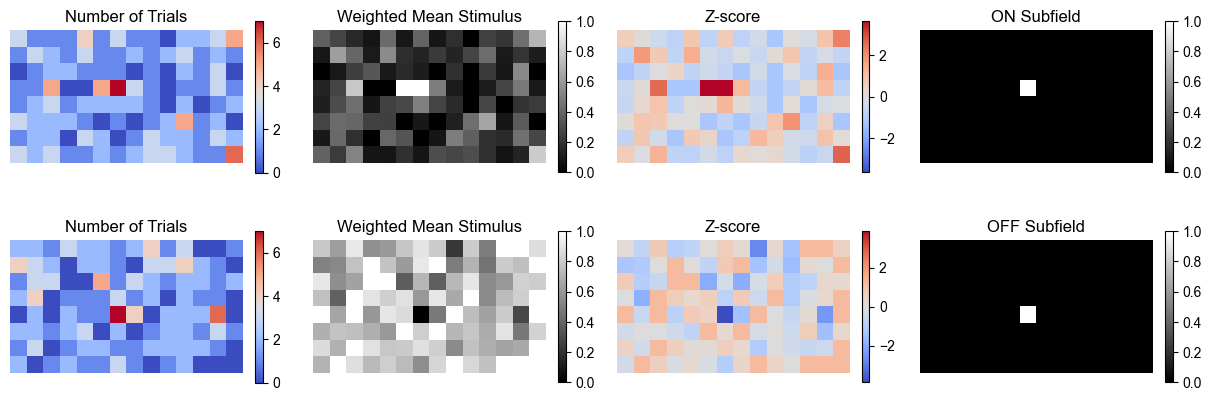

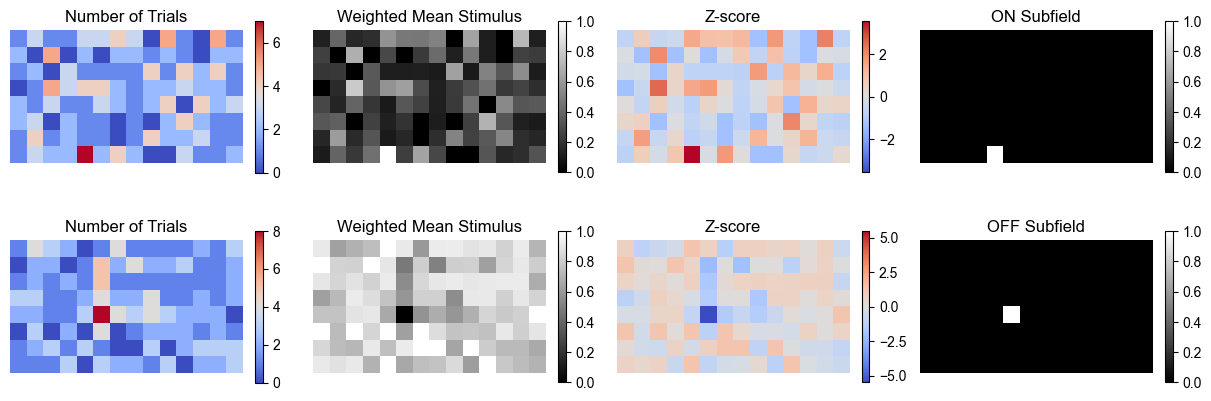

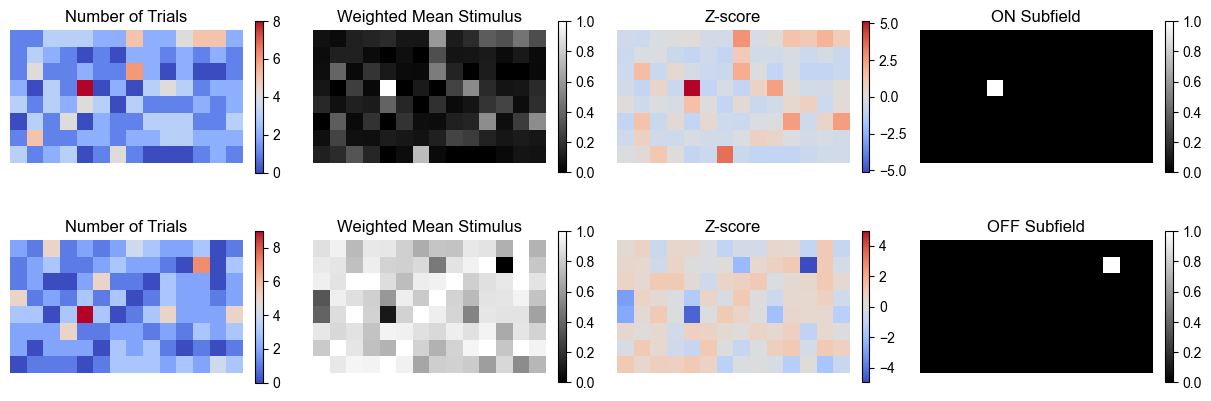

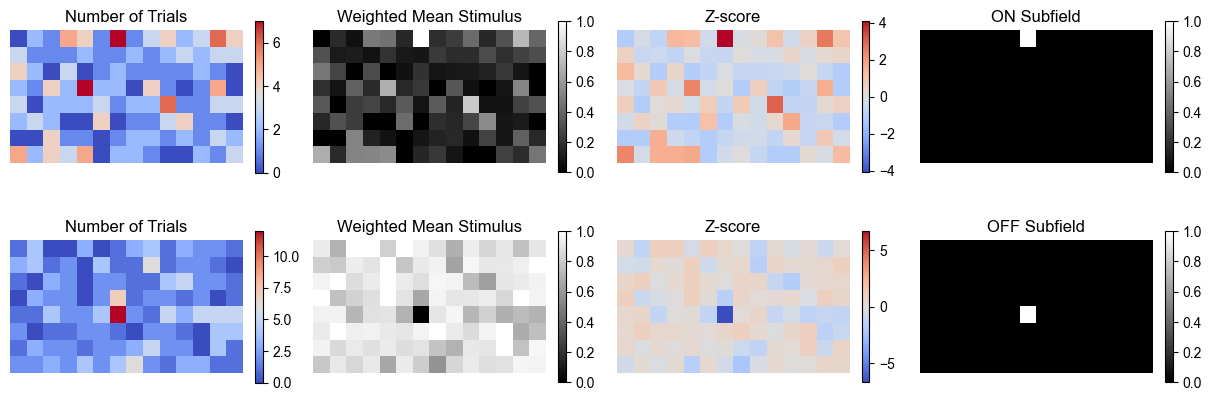

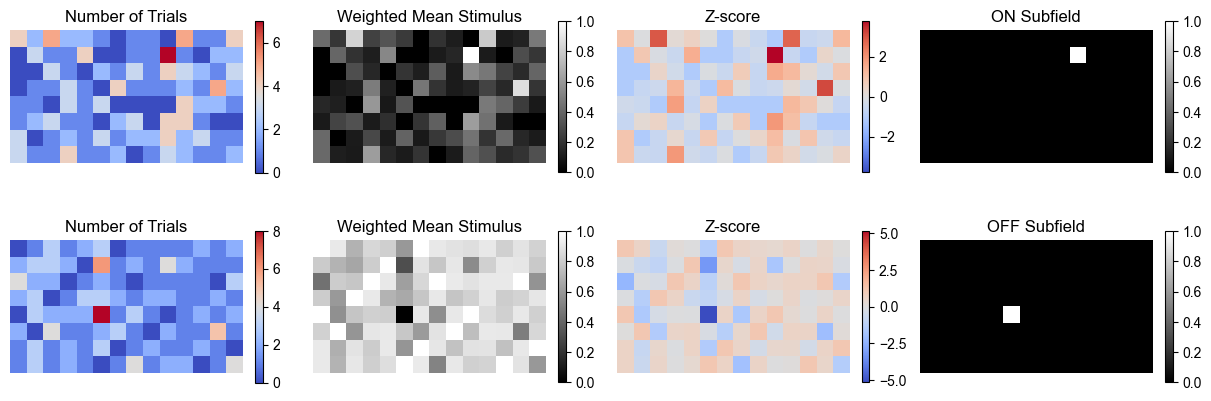

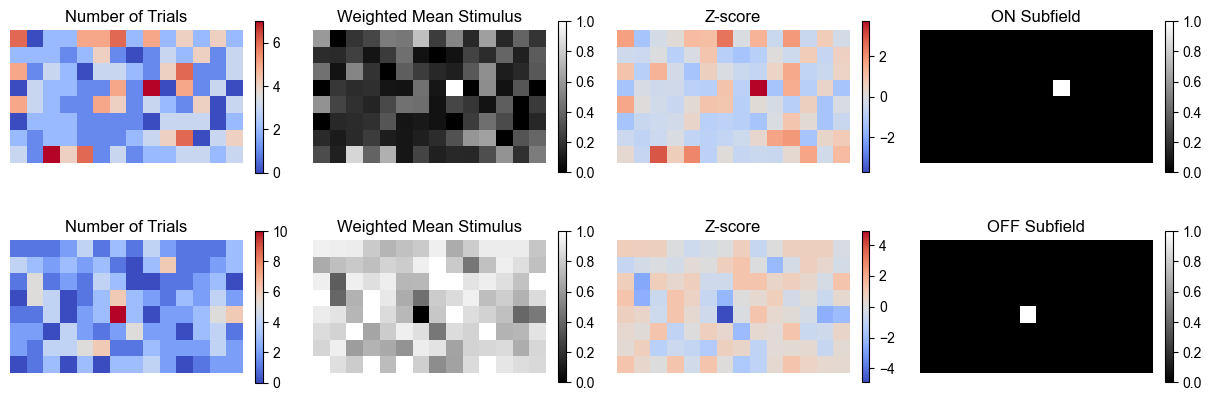

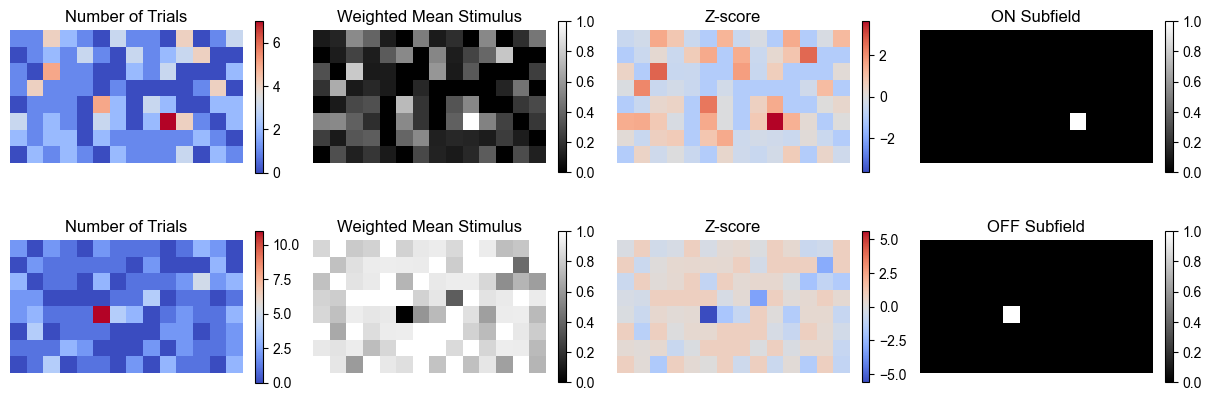

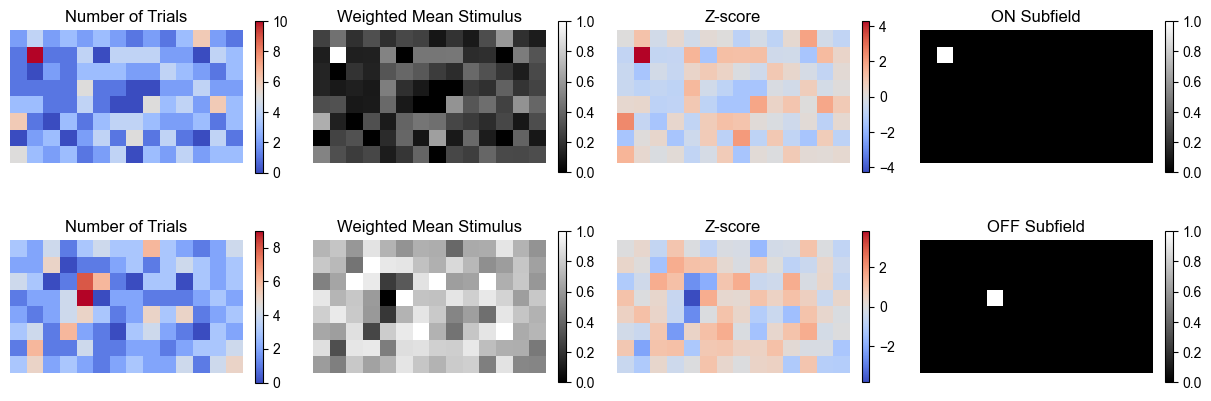

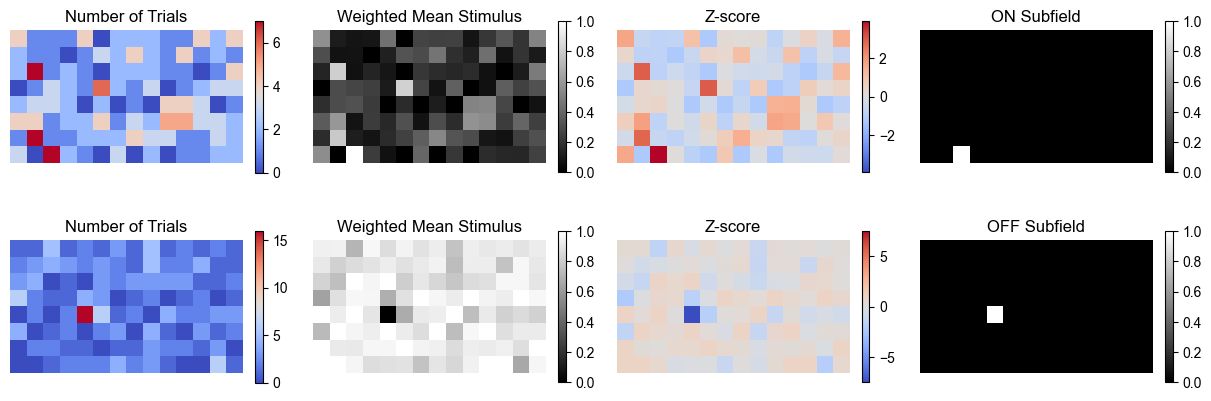

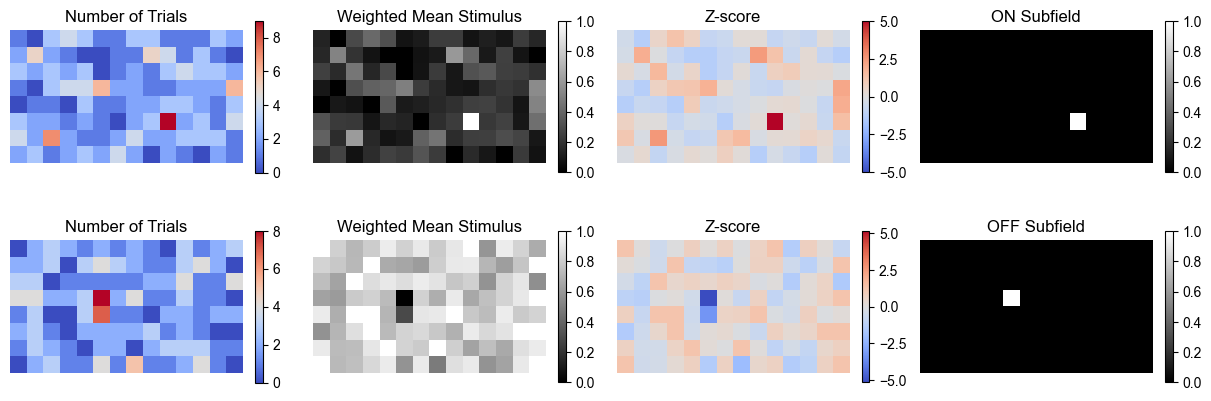

In [439]:
# find On/Off subfield if it exists 

for cell in range(542):
    lsn_values = all_lsn_vals_in_colvol_plane[:, cell]
    pvals = all_pvals_in_colvol_plane[:, cell]
    is_trial_responsive = pvals < response_thresh_alpha
    num_responsive_trials = np.sum(is_trial_responsive)

    design_matrix_for_resp_trials = design_matrix[:, is_trial_responsive] # design matrix for responsive trials
    weighted_avg_for_resp_trials = design_matrix_for_resp_trials.dot(lsn_values[is_trial_responsive]) # weighted (by lsn value) average of responsive stimuli 

    # split into on and off trials
    weighted_avg_for_resp_trials_on = weighted_avg_for_resp_trials[:int(len(weighted_avg_for_resp_trials)/2)]
    weighted_avg_for_resp_trials_off = weighted_avg_for_resp_trials[int(len(weighted_avg_for_resp_trials)/2):]

    # calculate ON subfield (if it exists)
    on_pixels = design_matrix_for_resp_trials[:112].reshape(8, 14, design_matrix_for_resp_trials.shape[1]) # pull out the on pixels from "responsive trials"
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)                       # convert to actual pixel values (for plotting later)
    mean_stim_for_resp_trials_on = on_pixels.mean(axis=2)                                                  # mean stimulus for on pixels of responsive trials
    mean_stim_for_resp_trials_on_weighted = (on_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_on = (mean_stim_for_resp_trials_on_weighted - mean_stim_for_resp_trials_on_weighted.mean()) / mean_stim_for_resp_trials_on_weighted.std() # z-score for on pixels
    counts_stim_for_resp_trials_on = design_matrix_for_resp_trials.sum(axis=1)[:112].reshape(8, 14)        # number of trials for each pixel
    on_results = (z_value_results_on > 3.5) & (counts_stim_for_resp_trials_on >= 7)  # threshold for significance

    # calculate OFF subfield (if it exists)
    off_pixels = design_matrix_for_resp_trials[112:].reshape(8, 14, design_matrix_for_resp_trials.shape[1])
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    mean_stim_for_resp_trials_off = off_pixels.mean(axis=2)
    mean_stim_for_resp_trials_off_weighted = (off_pixels * lsn_values[is_trial_responsive]).mean(axis=2)     # weighted mean stimulus for on pixels of responsive trials
    z_value_results_off = (mean_stim_for_resp_trials_off_weighted - mean_stim_for_resp_trials_off_weighted.mean()) / mean_stim_for_resp_trials_off_weighted.std()
    counts_stim_for_resp_trials_off = design_matrix_for_resp_trials.sum(axis=1)[112:].reshape(8, 14)
    off_results = (z_value_results_off < -3.5) & (counts_stim_for_resp_trials_off >= 7)  # threshold for significance

    # check for islands 
    if on_results.sum() > 0:
        on_subfield = True
        on_subfield_pixels = np.where(on_results == True)
        on_center = np.mean(on_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an ON subfield, {on_subfield_pixels}')

    if off_results.sum() > 0:
        off_subfield = True
        off_subfield_pixels = np.where(off_results == True)
        off_center = np.mean(off_subfield_pixels, axis=1)
        # print(f'Cell {cell} has an OFF subfield, {off_subfield_pixels}')

    on_subfield = []

    if np.sum(on_results) > 1:
        # print(f'Cell {cell} has multiple ON subfields')
        biggest_on_subfield = np.where(z_value_results_on == z_value_results_on.max())
        on_subfield.append([biggest_on_subfield[0][0], biggest_on_subfield[1][0]])
        
        for x, y in zip(on_subfield_pixels[0], on_subfield_pixels[1]):
            distance = np.sqrt((x - biggest_on_subfield[0])**2 + (y - biggest_on_subfield[1])**2)
            if distance < 1.5:
                on_subfield.append([x, y])
                
            for idx in range(len(on_subfield) - 1):
                # print(idx)
                x, y = on_subfield[idx][0], on_subfield[idx][1]
                # print(f'\tDistance between biggest ON subfield and other ON subfields {distance}')
                # print(x, y)

    elif np.sum(on_results) == 1:
        on_subfield.append([on_subfield_pixels[0][0], on_subfield_pixels[1][0]])

    on_subfield = np.array(on_subfield)
    on_results_new = np.zeros_like(on_results)
    if on_subfield.size > 0:
        on_results_new[on_subfield[:, 0], on_subfield[:, 1]] = 1

    off_subfield = []

    if np.sum(off_results) > 1:
        biggest_off_subfield = np.where(z_value_results_off == z_value_results_off.min())
        off_subfield.append([biggest_off_subfield[0][0], biggest_off_subfield[1][0]])
        
        for x, y in zip(off_subfield_pixels[0], off_subfield_pixels[1]):
            distance = np.sqrt((x - biggest_off_subfield[0])**2 + (y - biggest_off_subfield[1])**2)
            if distance < 1.5:
                off_subfield.append([x, y])
                
            for idx in range(len(off_subfield) - 1):
                # print(idx)
                x, y = off_subfield[idx][0], off_subfield[idx][1]
                # print(f'\tDistance between biggest OFF subfield and other OFF subfields {distance}')
                # print(x, y)

    elif np.sum(off_results) == 1:
        off_subfield.append([off_subfield_pixels[0][0], off_subfield_pixels[1][0]])
        
    off_subfield = np.array(off_subfield)
    off_results_new = np.zeros_like(off_results)
    if off_subfield.size > 0:
        off_results_new[off_subfield[:, 0], off_subfield[:, 1]] = 1

    # plt.tight_layout()
    # fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.95)

    if on_results_new.sum() > 0 and off_results_new.sum() > 0:
        print(f'Cell {cell} has both ON and OFF subfields')
        print(f'\tDistance between ON and OFF subfields {np.sqrt((on_center[0] - off_center[0])**2 + (on_center[1] - off_center[1])**2)}')

        fig, axs = plt.subplots(2, 4, figsize=(15, 5))

        # norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
        # sub1 = axs[0, 0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
        # fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        # axs[0, 0].set_title('Mean Stimulus')
        # axs[0, 0].axis('off')

        sub1 = axs[0, 0].imshow(counts_stim_for_resp_trials_on, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[0, 0], fraction=0.03)
        axs[0, 0].set_title('Number of Trials')
        axs[0, 0].axis('off')

        norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
        sub2 = axs[0, 1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[0, 1], fraction=0.03)
        axs[0, 1].set_title('Weighted Mean Stimulus')
        axs[0, 1].axis('off')

        sub3 = axs[0, 2].imshow(z_value_results_on, cmap='coolwarm', vmin=-np.abs(z_value_results_on).max(), vmax=np.abs(z_value_results_on).max())
        fig.colorbar(sub3, ax=axs[0, 2], fraction=0.03)
        axs[0, 2].set_title('Z-score')
        axs[0, 2].axis('off')

        sub4 = axs[0, 3].imshow(on_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[0, 3], fraction=0.03)
        axs[0, 3].set_title('ON Subfield')
        axs[0, 3].axis('off')

        sub1 = axs[1, 0].imshow(counts_stim_for_resp_trials_off, cmap='coolwarm')
        fig.colorbar(sub1, ax=axs[1, 0], fraction=0.03)
        axs[1, 0].set_title('Number of Trials')
        axs[1, 0].axis('off')

        norm_mean_stim_for_resp_trials_off_weighted = (mean_stim_for_resp_trials_off_weighted - np.min(mean_stim_for_resp_trials_off_weighted)) / (np.max(mean_stim_for_resp_trials_off_weighted) - np.min(mean_stim_for_resp_trials_off_weighted))
        sub2 = axs[1, 1].imshow(norm_mean_stim_for_resp_trials_off_weighted, cmap='gray')
        fig.colorbar(sub2, ax=axs[1, 1], fraction=0.03)
        axs[1, 1].set_title('Weighted Mean Stimulus')
        axs[1, 1].axis('off')

        sub3 = axs[1, 2].imshow(z_value_results_off, cmap='coolwarm', vmin=-np.abs(z_value_results_off).max(), vmax=np.abs(z_value_results_off).max())
        fig.colorbar(sub3, ax=axs[1, 2], fraction=0.03)
        axs[1, 2].set_title('Z-score')
        axs[1, 2].axis('off')

        sub4 = axs[1, 3].imshow(off_results_new, cmap='gray', vmin=0, vmax=1)
        fig.colorbar(sub4, ax=axs[1, 3], fraction=0.03)
        axs[1, 3].set_title('OFF Subfield')
        axs[1, 3].axis('off')

# plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)



NameError: name 'mean_stim_for_resp_trials_on_weighted' is not defined

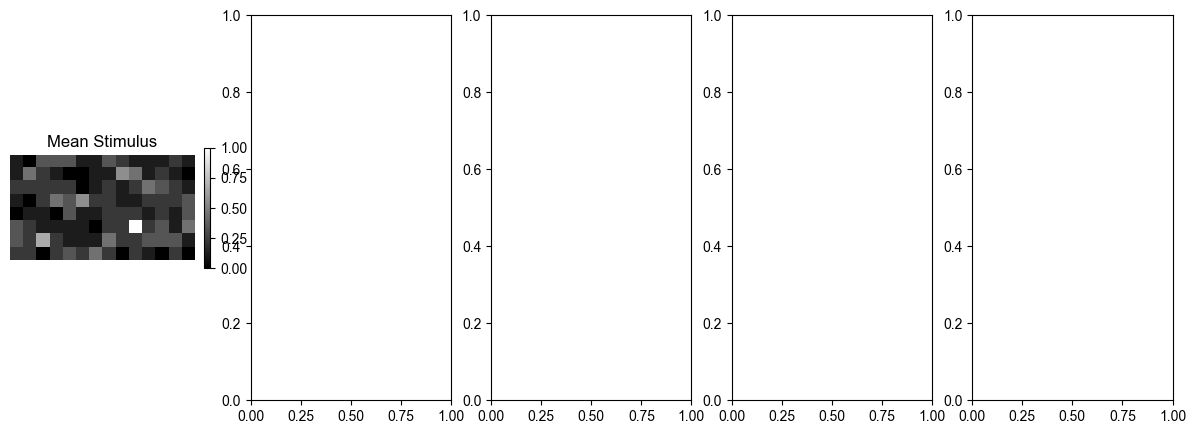

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

norm_mean_stim_for_resp_trials_on = (mean_stim_for_resp_trials_on - np.min(mean_stim_for_resp_trials_on)) / (np.max(mean_stim_for_resp_trials_on) - np.min(mean_stim_for_resp_trials_on))
sub1 = axs[0].imshow(norm_mean_stim_for_resp_trials_on, cmap='gray')
fig.colorbar(sub1, ax=axs[0], fraction=0.03)
axs[0].set_title('Mean Stimulus')
axs[0].axis('off')

norm_mean_stim_for_resp_trials_on_weighted = (mean_stim_for_resp_trials_on_weighted - np.min(mean_stim_for_resp_trials_on_weighted)) / (np.max(mean_stim_for_resp_trials_on_weighted) - np.min(mean_stim_for_resp_trials_on_weighted))
sub2 = axs[1].imshow(norm_mean_stim_for_resp_trials_on_weighted, cmap='gray')
fig.colorbar(sub2, ax=axs[1], fraction=0.03)
axs[1].set_title('Weighted Mean Stimulus')
axs[1].axis('off')

sub3 = axs[2].imshow(z_value_results, cmap='coolwarm', vmin=-3, vmax=3)
fig.colorbar(sub3, ax=axs[2], fraction=0.03)
axs[2].set_title('Z-score')
axs[2].axis('off')

sub4 = axs[3].imshow(on_results, cmap='gray', vmin=0, vmax=1)
fig.colorbar(sub4, ax=axs[3], fraction=0.03)
axs[3].set_title('ON Subfield')
axs[3].axis('off')

sub5 = axs[4].imshow(off_results, cmap='gray_r', vmin=0, vmax=1)
fig.colorbar(sub5, ax=axs[4], fraction=0.03)
axs[4].set_title('OFF Subfield')
plt.xticks([])
plt.yticks([])

# plt.tight_layout()
fig.suptitle(f'Cell {cell} Subfield Analysis', y=0.7)

plt.savefig(figure_path / f'cell_{cell}_subfield_analysis.png', dpi=300)

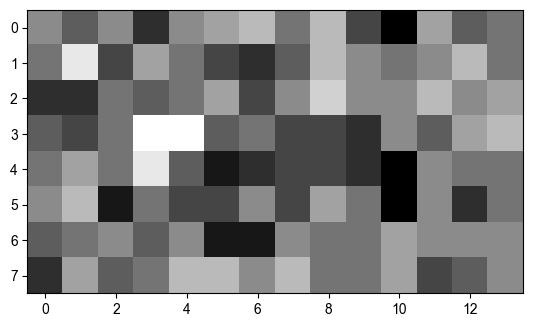

In [ ]:
plt.imshow(mean_stim_for_resp_trials, cmap='gray')

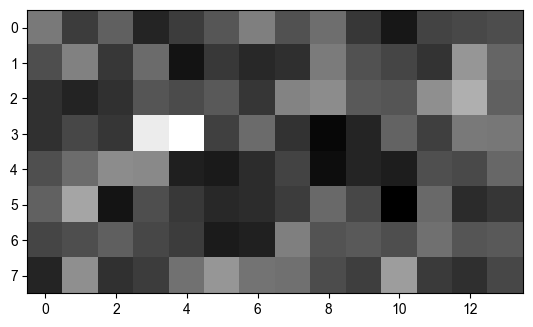

In [ ]:
plt.imshow(mean_stim_for_resp_trials_weighted, cmap='gray')

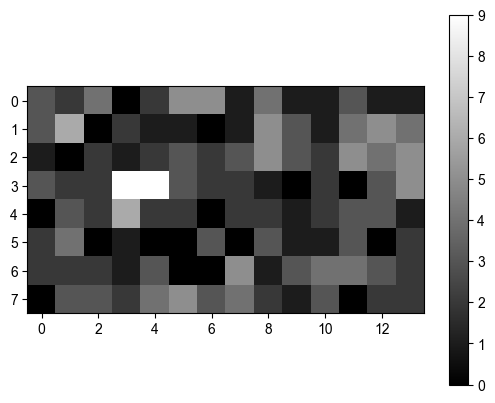

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(design_matrix_for_resp_trials[])

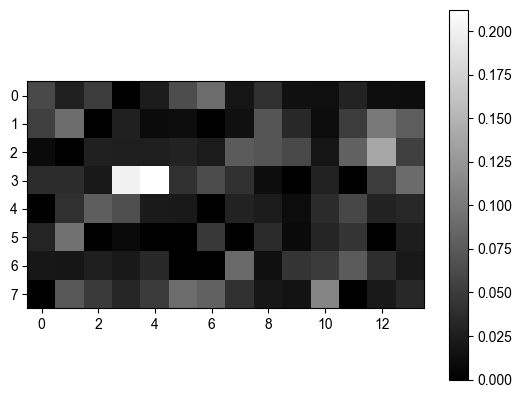

In [ ]:
plt.imshow(weighted_avg_for_resp_trials_on.reshape(8, 14), cmap='gray')
plt.colorbar()

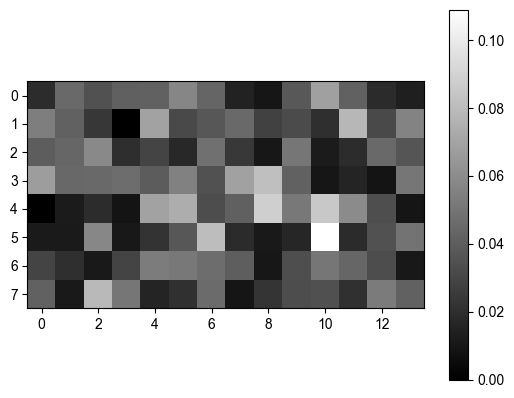

In [ ]:
plt.imshow(weighted_avg_for_resp_trials_off.reshape(8, 14), cmap='gray')
plt.colorbar()

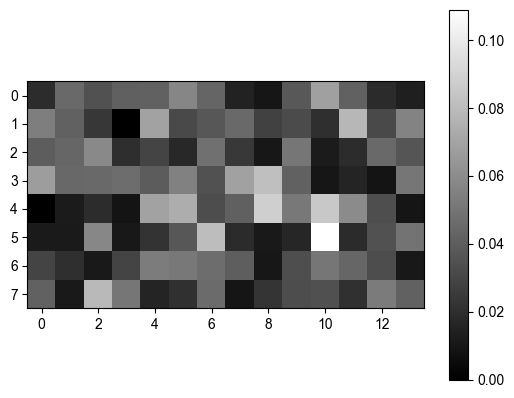

In [ ]:
plt.imshow(weighted_avg_for_resp_trials[-112:].reshape(8, 14), cmap='gray')
plt.colorbar()